In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, shapiro, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest 
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

### 1. Анализ структуры и предобработка данных

In [3]:
data = pd.read_csv('marketing_AB.csv')
data.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


Данные представлены следующими полями:

- **user id:** Идентификатор пользователя (уникальный);
- **test group:** Если "ad", то человек видел рекламу, если "psa", то он видел только объявление государственной службы;
- **converted:** Если человек купил продукт, то True, иначе False;
- **total ads:** Количество рекламы, увиденной человеком;
- **most ads day:** День, в который человек увидел наибольшее количество рекламы;
- **most ads hour:** Час дня, в который человек увидел наибольшее количество рекламы.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null  object
 6   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB


Пропусков в данных нет. Сразу удалим за очевидной ненадобностью столбец Unnamed: 0 и проверим, есть ли пользователи, попавшие в обе группы. Тип данных соответствует значениям каждого из столбцов.

In [7]:
data = data.drop('Unnamed: 0', axis=1)
data.head()

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


Проверка пользователей, которые могли попасть в обе группы:

In [9]:
intersection_users = list(set(data[data['test group'] == 'ad']['user id'].values) & \
set(data[data['test group'] == 'psa']['user id'].values))
print('Кол-во пользователей, попавших в обе группы:', len(intersection_users))

Кол-во пользователей, попавших в обе группы: 0


### 2. Первичный анализ результатов A/B-теста

Рассчитаем количествово посещений сайта и суммарное количество совершенных покупок.

In [11]:
grouped_data = data.groupby('test group').agg({
    'user id': 'count',
    'converted': 'sum',
}).rename({'user id': 'count of visits', 
           'converted': 'count of purchases'}, axis=1)
grouped_data

,count of visits,count of purchases
test group,,
ad,564577,14423
psa,23524,420


**Промежуточный вывод:** выборки несбалансированы, количество посещений сайта в группах не сопоставимо.

Рассчитаем показатели конверсии для каждой группы.

In [13]:
grouped_data['conversion'] = (grouped_data['count of purchases'] / grouped_data['count of visits']) * 100
grouped_data

,count of visits,count of purchases,conversion
test group,,,
ad,564577,14423,2.554656
psa,23524,420,1.785411


Рассчитаем среднее количество рекламы, увиденной пользователем.

In [15]:
avg_ad_seen = data.groupby('test group')['total ads'].mean()
grouped_data = grouped_data.merge(avg_ad_seen, on='test group')
grouped_data

,count of visits,count of purchases,conversion,total ads
test group,,,,
ad,564577,14423,2.554656,24.823365
psa,23524,420,1.785411,24.761138


**Первичный вывод:** Конверсия для группы ad составляет 2.55, что выше показателя конверсии для группы psa, которая составляет 1.78. Среднее количество рекламы, увиденной пользователем, в обеих группах примерно одинаковое. Исходя из этих результатов можно сделать предварительный вывод, что реклама влияет на величину конверсии.

### 3. Cтатистический анализ результатов A/B-тестирования

**1) Исследуем различия по конверсиям групп.**

Сформулируем статистические гипотезы (от обратного исходя из первичного вывода):
- $H_0:$ конверсия в группе А (ad) не больше, чем в группе В (psa)
- $H_1:$ конверсии в группе A больше, чем в группе В

Будем использовать Z-тест для пропорций, потому что выборка большая.

In [17]:
# вычисляем значение p-value для z-теста для пропорций
alpha = 0.05
_, p_value = proportions_ztest(
    count=grouped_data['count of purchases'], #число «успехов»
    nobs=grouped_data['count of visits'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', p_value)
# сравниваем полученное p-value с уровнем значимости
if (p_value <= alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value:  8.526403580779863e-14
Отвергаем нулевую гипотезу в пользу альтернативной


Делаем вывод, что в группе А с показом рекламы с большой долей вероятности конверсия выше.

Рассчитаем доверительный интервал для конверсий.

In [19]:
def proportion_conf_interval(x_p, n, gamma=0.95):  
    alpha = 1 - gamma 
    z_crit = -norm.ppf(alpha/2) 
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 
    lower_bound = x_p - eps 
    upper_bound = x_p + eps 
    return lower_bound, upper_bound

Разделим данные по выборкам.

In [21]:
A = data[data['test group'] == 'ad']
B = data[data['test group'] == 'psa']

Доверительный интервал для конверсии в группе А: (2.35, 2.76)
Доверительный интервал для конверсии в группе B: (1.62, 1.95)


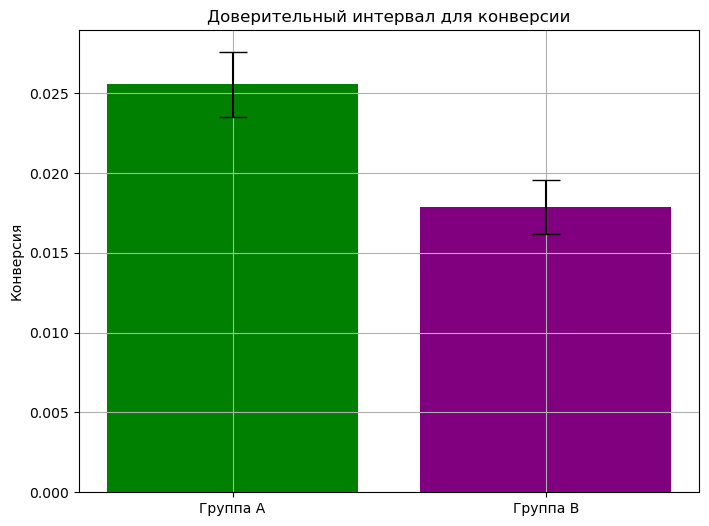

In [23]:
# доверительный интервал для конверсии в группе А
lower_bound_a, upper_bound_a  = proportion_conf_interval(
    x_p=A['converted'].mean(), 
    n=B['user id'].count() 
)

# доверительный интервал для конверсии в группе B
lower_bound_b, upper_bound_b  = proportion_conf_interval(
    x_p=B['converted'].mean(), 
    n=B['user id'].count() 
)

print('Доверительный интервал для конверсии в группе А: {}'.format((round(lower_bound_a * 100, 2), round(upper_bound_a * 100, 2))))
print('Доверительный интервал для конверсии в группе B: {}'.format((round(lower_bound_b * 100, 2), round(upper_bound_b * 100, 2))))

# визуализация данных
groups = ['Группа А', 'Группа B']
means = [A['converted'].mean(), B['converted'].mean()]
ci_lowers = [lower_bound_a, lower_bound_b]
ci_uppers = [upper_bound_a, upper_bound_b]

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(groups, means, yerr=[np.subtract(means, ci_lowers), np.subtract(ci_uppers, means)], capsize=10, color=['green', 'purple'])
ax.set_ylabel('Конверсия')
ax.set_title('Доверительный интервал для конверсии')
ax.grid(True)

plt.show()

Доверительные интервалы не пересекаются, что свидетельствует о наличии разницы между конверсиями двух групп.

Произведем расчет доверительного интервала для разницы конверсий.

In [25]:
def diff_proportion_conf_interval(x_p, n, gamma=0.95):
    alpha = 1 - gamma 
    diff = x_p[1] - x_p[0] 
    z_crit = -norm.ppf(alpha/2) 
    eps = z_crit * (x_p[0] * (1 - x_p[0])/n[0] + x_p[1] * (1 - x_p[1])/n[1]) ** 0.5 
    lower_bound = diff - eps 
    upper_bound = diff + eps 
    return lower_bound, upper_bound

In [27]:
n = [A['user id'].count(), B['user id'].count()]
x_p = [A['converted'].mean(), B['converted'].mean()]
lower_bound, upper_bound = diff_proportion_conf_interval(x_p=x_p, n=n)

print('Доверительный интервал для разности конверсий: {}'.format((round(lower_bound*100, 2), round(upper_bound*100, 2))))

Доверительный интервал для разности конверсий: (-0.94, -0.6)


Интервал полностью отрицательный. Это значит, что варианты А и B не равнозначны по метрике конверсии. Отсюда можно сделать вывод, что существует статистическая разница в конверсии между вариантами А и B, то есть по данной метрике группа B уступает.

**1) Исследуем различия по среднему количеству увиденной рекламмы в группах.**

Сформулируем статистические гипотезы (исходя из первичного вывода):
- $H_0:$ среднее количество увиденной рекламы не отличается в группах А и В
- $H_1:$ среднее количество увиденной рекламы отличается в группах А и В

Посмотрим на распределение данных на графиках.

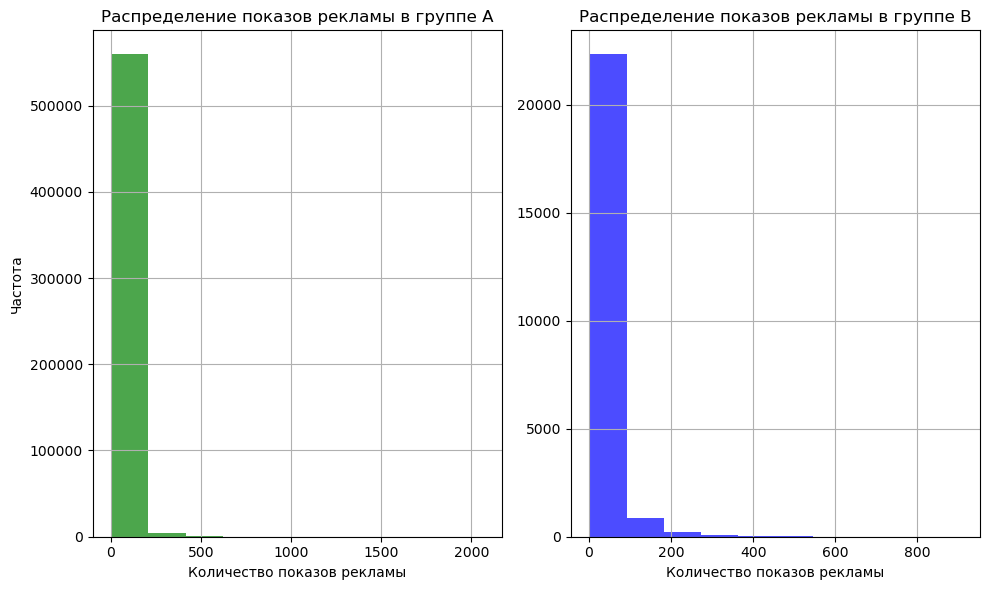

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

# группа A
ax1.hist(A['total ads'], bins=10, alpha=0.7, color='green')
ax1.set_title('Распределение показов рекламы в группе А')
ax1.set_xlabel('Количество показов рекламы')
ax1.set_ylabel('Частота')
ax1.grid(True)

# группа B 
ax2.hist(B['total ads'], bins=10, alpha=0.7, color='blue')
ax2.set_title('Распределение показов рекламы в группе B')
ax2.set_xlabel('Количество показов рекламы')
ax2.grid(True)

plt.tight_layout()
plt.show()

Исходя из графиков мы видим, что данные распределены не нормально. Убедимся в этом также с помощью теста Шапиро-Уилка.

In [31]:
shapiro_result_a = shapiro(A['total ads'])
shapiro_result_b = shapiro(B['total ads'])
print('p-value группы А', shapiro_result_a.pvalue)
print('p-value группы B', shapiro_result_b.pvalue)

# сравниваем полученное p-value для группы А с уровнем значимости
if shapiro_result_a.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе А отлично от нормального")
else:
    print("Принимаем нулевую гипотезу. Распределение в группе А является нормальным")

# сравниваем полученное p-value для группы B с уровнем значимости
if shapiro_result_b.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе B отлично от нормального")
else:
    print("Принимаем нулевую гипотезу. Распределение в группе B является нормальным")

p-value группы А 3.701044472444164e-203
p-value группы B 7.270789402370636e-120
Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе А отлично от нормального
Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе B отлично от нормального


Так как данные распределены не нормально, далее нам придётся обратиться к непараметрическим тестам, например, к критерию Манна — Уитни (U-тест).

In [33]:
results = mannwhitneyu(
    x=A['total ads'],
    y=B['total ads'],
    alternative='two-sided'
)
print('p-value:', results.pvalue)

# сравниваем полученное p-value с уровнем значимости
if results.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value: 4.6909108547205694e-11
Отвергаем нулевую гипотезу в пользу альтернативной


Из чего делаем вывод, что существует статистическая разница между количеством увиденной рекламы в группах.

Произведем расчет доверительного интервала.

In [35]:
def z_mean_conf_interval(x_mean, sigma, n, gamma=0.95):  
    alpha = 1 - gamma  
    z_crit = -norm.ppf(alpha/2) 
    eps = z_crit * sigma/(n ** 0.5)
    lower_bound = x_mean - eps  
    return lower_bound, upper_bound

# стандартное отклонение и среднее значение для группы А
sigma_A = A['total ads'].std()
x_mean_A = A['total ads'].mean()
n_A = A['total ads'].count()
lower_boundA, upper_boundA = z_mean_conf_interval(x_mean_A, sigma_A, n_A)

# стандартное отклонение и среднее значение для группы В
sigma_B = B['total ads'].std()
x_mean_B = B['total ads'].mean()
n_B = B['total ads'].count()
lower_boundB, upper_boundB = z_mean_conf_interval(x_mean_B, sigma_B, n_B)


print('Доверительный интервал среднего количества увиденной рекламы в группе A: {}'.format((round(lower_boundA,2), round(upper_boundA,2))))
print('Доверительный интервал среднего количества увиденной рекламы в группе B: {}'.format((round(lower_boundB,2), round(upper_boundB,2))))

Доверительный интервал среднего количества увиденной рекламы в группе A: (24.71, -0.01)
Доверительный интервал среднего количества увиденной рекламы в группе B: (24.21, -0.01)


Построим также визуализацию доверительных интервалов.

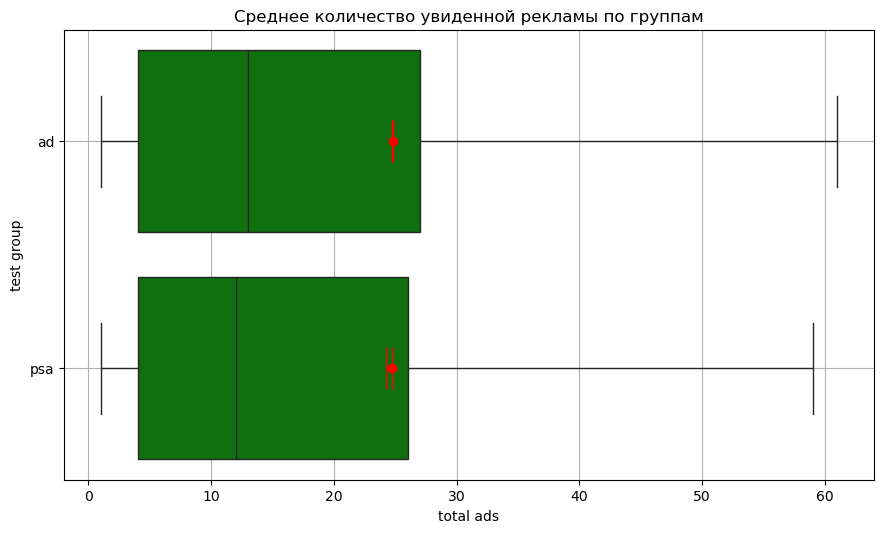

In [37]:
fig = plt.figure(figsize=(9, 5))
ax = fig.add_axes([0.1, 0.1, 0.9, 0.9]) 

sns.boxplot(data=data, x='total ads', y='test group', ax=ax, showfliers=False, color='green')
ax.set_title('Среднее количество увиденной рекламы по группам')
ax.grid(True)

positions = [0, 1]
means = [x_mean_A, x_mean_B]
ci_lower_bounds = [lower_boundA, lower_boundB]
ci_upper_bounds = [upper_boundA, upper_boundB]

for pos, mean, lower, upper in zip(positions, means, ci_lower_bounds, ci_upper_bounds):
    lower_error = max(0, mean - lower)  
    upper_error = max(0, upper - mean)  
    
    ax.errorbar(x=mean, y=pos, xerr=[[lower_error], [upper_error]], fmt='o', color='red', capsize=15)

plt.show()

Доверительные интервалы практически одинаковые, а значит, что среднее число увиденной рекламы в группах не отличается.

**Общий вывод:** Таким образом, можно заключить, что количество показов рекламы в обеих группах не отличается. Несмотря на то, что результаты теста Манна-Уитни показали статистически значимое различие, значения доверительных интервалов указывают на отсутствие различий между средними показателями в обеих группах. Это позволяет нам утверждать, что влияние фактора было одинаковым в обеих группах. В то же время конверсия оказалась значительно выше в группе с рекламой, что было подтверждено как результатами Z-теста пропорций, так и расчетами доверительных интервалов для конверсий и разницы между ними. Исходя из вышеизложенного, можно утверждать, что успех рекламной кампании обоснован именно рекламой, и реклама может принести компании прибыль.